<a href="https://colab.research.google.com/github/aLehav/Olami/blob/main/Article_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working Templated Sentiment

In [1]:
STRING='Hillel'
CSV_NAME='hypothesis_sentiment_results'
DF_PATH='ucf_hillel.csv'

In [2]:
!pip install transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 81.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.0 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import matplotlib.pyplot as plt

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Check and set device
nli_model = AutoModelForSequenceClassification.from_pretrained('facebook/bart-large-mnli').to(device)
tokenizer = AutoTokenizer.from_pretrained('facebook/bart-large-mnli')

In [7]:
def compute_sentiment(row):
    text_entries = row['matching_text']
    scores = []
    for text_entry in text_entries:
      scores.append(tuple(get_sentiment_pytorch(text=text_entry, string=STRING)))
      torch.cuda.empty_cache()
    print(np.average(scores, axis=0))
    return np.average(scores, axis=0)

def get_sentiment_pytorch(text, string):
    premise = text
    labels = ['positive','negative','neutral']
    hypotheses = [f'This example is {label} towards {string}.' for label in labels]

    # Tokenize all premises and hypotheses
    inputs = tokenizer.batch_encode_plus(
        [(premise, hypothesis) for hypothesis in hypotheses],
        truncation=True,
        padding=True,
        return_tensors='pt'
    )
    
    # Run through model pre-trained on MNLI
    logits = nli_model(**inputs.to(device)).logits

    # Calculate probabilities
    entail_contradiction_logits = logits[:, [0, 2]]
    probs = entail_contradiction_logits.softmax(dim=1)
    prob_label_is_true = probs[:, 1]

    return prob_label_is_true.tolist()

def plot_sentiment_over_time(df):
    # Set up the figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data
    ax.plot(df['date'], df['positive'], label='Positive')
    ax.plot(df['date'], df['negative'], label='Negative')
    ax.plot(df['date'], df['neutral'], label='Neutral')

    # Set the title and axis labels
    ax.set_title(f'UCF {STRING} Sentiment Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sentiment')
    
    # Rotate x-axis tick labels for better visibility
    plt.xticks(rotation=60)

    # Add a legend
    ax.legend()

    # Adjust the figure layout
    fig.tight_layout()

    # Save the plot
    plt.savefig('base_sentiment_results.png', bbox_inches='tight')

    # Show the plot
    plt.show()

[0.85544986 0.02847675 0.04757294]
[0.82820231 0.20172155 0.33256611]
[0.09061325 0.1086525  0.04800816]
[0.21911681 0.27574378 0.10071074]
[0.84505904 0.61437088 0.51730007]
[0.83915025 0.46421853 0.64023423]
[0.37770334 0.91354829 0.57950485]
[0.58100158 0.30642039 0.0312773 ]
[0.52494401 0.11244688 0.00967856]
[0.29729977 0.75606626 0.36834136]
[0.84816927 0.0830879  0.10136977]
[0.394766   0.04330602 0.01562359]
[0.97208458 0.18457513 0.2892859 ]


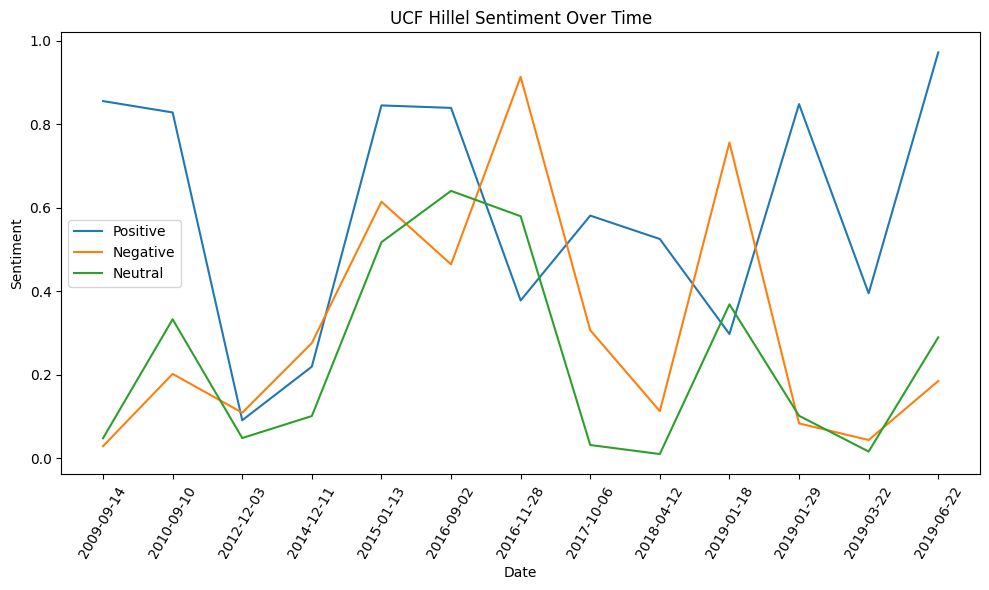

In [8]:
df = pd.read_csv(DF_PATH,index_col=0)
df['matching_text'] = df['matching_text'].apply(eval) 
df[['positive', 'negative', 'neutral']] = df.apply(compute_sentiment, axis=1, result_type='expand')
df[['date','positive','negative','neutral']].to_csv(f'{CSV_NAME}.csv')
df[['school','date','txt_file','matching_text', 'matching_links','positive','negative','neutral']].to_csv(f'{CSV_NAME}_expanded.csv')
plot_sentiment_over_time(df)